# Experiment 1: Tuning AIMD parameters

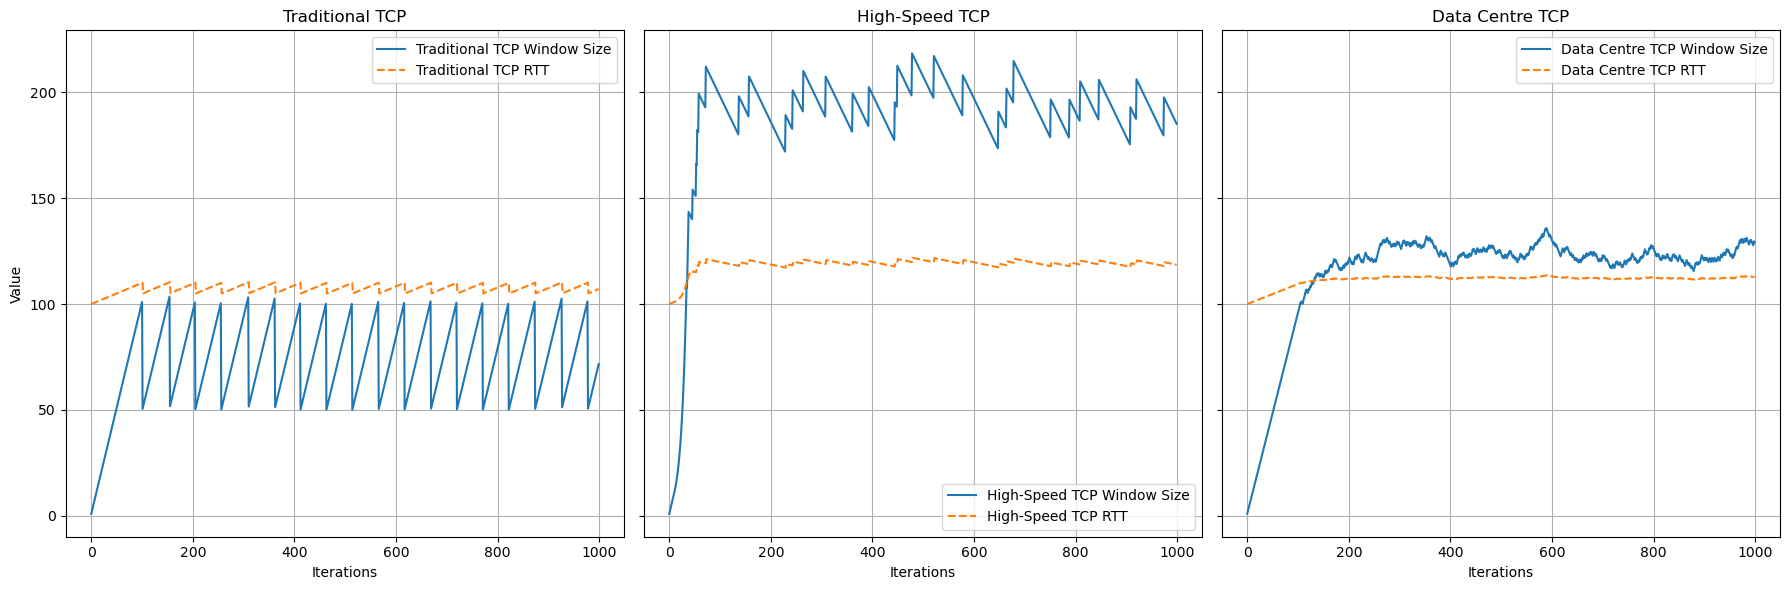

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Constants
ITERATIONS = 1000 
BASE_RTT = 100
C = 100  # Constant to control RTT increase and packet loss probability
WEIGHT = 0.1  # Weight for DCTCP
ecn_marking_prob = 0.05  # ECN marking probability for DCTCP


# Helper function to simulate network response
def network_response(window_size):
    # Increase RTT as window size increases
    new_rtt = BASE_RTT + window_size * 10 / C
    
    # Random packet loss if window size is too large
    if window_size > C:
        loss_probability = window_size / (2 * C)
        loss = np.random.rand() < loss_probability
    else:
        loss = False    
    return new_rtt, loss


# Function for High-Speed TCP alpha calculation
def hstcp_alpha(cwnd, rtt=None):
    # alpha grows as the window size increases to allow for faster window growth
    return max(1, cwnd / 10)  

def hstcp_beta(cwnd, rtt=None):
    # beta decreases as the window size increases to allow for less aggressive window shrinkage
    return max(0.5, 1 - (1 / (2 * cwnd))) 


# TCP Types parameters
tcp_types = {
    "Traditional TCP": {
        "alpha": lambda cwnd, rtt: 1, 
        "beta": lambda cwnd, rtt: 0.5
    },
    "High-Speed TCP": {
        "alpha": hstcp_alpha, 
        "beta": hstcp_beta 
    },
    "Data Centre TCP": {
        "alpha": lambda cwnd, rtt: 1 - ecn_marking_prob,
        "beta": lambda cwnd, rtt: 1 - (WEIGHT * ecn_marking_prob)
    }
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, (tcp_type, params) in enumerate(tcp_types.items()):
    # Initialization
    window_size = 1 
    window_sizes = [window_size]  # To store window sizes over time
    rtts = [BASE_RTT]  # To store RTTs over time, starting with the base RTT
    
    # Simulation loop
    for i in range(1, ITERATIONS):
        # Simulate network response
        rtt, packet_loss = network_response(window_size)
        rtts.append(rtt)
        
        # Get alpha and beta for the current window size and RTT
        alpha = params["alpha"](window_size, rtt)
        beta = params["beta"](window_size, rtt)
        
        if packet_loss:
            # On packet loss, Multiplicative Decrease
            window_size *= beta
        else:
            # If no packet loss, Additive Increase
            window_size += alpha
        
        window_size = max(1, window_size)  # Ensure window size is at least 1
        window_sizes.append(window_size)

    # Plotting results
    ax = axs[idx]
    ax.plot(window_sizes, label=f'{tcp_type} Window Size')
    ax.plot(rtts, label=f'{tcp_type} RTT', linestyle='--')
    ax.set_xlabel('Iterations')
    if idx == 0:
        ax.set_ylabel('Value')
    ax.set_title(f'{tcp_type}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


# Experiment 2: Varying the number of TCP flows sharing a single bottleneck

In [110]:
def experiment2(n_users):
    
    # Constants
    ITERATESMAX = 1000 
    C = 100  # Capacity of the bottleneck link
    WEIGHT = 0.1  # Weight for DCTCP
    ecn_marking_prob = 0.05  # ECN marking probability for DCTCP
    
    # Define High-Speed TCP alpha and beta functions
    def hstcp_alpha(cwnd):
        return max(1, cwnd / 10)

    def hstcp_beta(cwnd):
        return max(0.5, 1 - (1 / (2 * cwnd)))
    
    # Initialize window sizes for all users for each TCP type
    window_sizes = {
        'Traditional TCP': np.ones(n_users),
        'High-Speed TCP': np.ones(n_users),
        'Data Centre TCP': np.ones(n_users)
    }
    
    # Store average window sizes over time for plotting for each TCP type
    average_window_sizes = {
        tcp_type: np.zeros(ITERATESMAX) for tcp_type in window_sizes
    }
    
    # Run simulation for each TCP type
    for tcp_type in window_sizes:
        for i in range(1, ITERATESMAX):
            total_cwnd = np.sum(window_sizes[tcp_type])
            if total_cwnd <= C:
                # Additive Increase
                if tcp_type == 'Traditional TCP':
                    window_sizes[tcp_type] += 1
                elif tcp_type == 'High-Speed TCP':
                    for u in range(n_users):
                        window_sizes[tcp_type][u] += hstcp_alpha(window_sizes[tcp_type][u])
                elif tcp_type == 'Data Centre TCP':
                    window_sizes[tcp_type] += 1 - ecn_marking_prob
            else:
                # Multiplicative Decrease
                if tcp_type == 'Traditional TCP':
                    window_sizes[tcp_type] *= 0.5
                elif tcp_type == 'High-Speed TCP':
                    for u in range(n_users):
                        window_sizes[tcp_type][u] *= hstcp_beta(window_sizes[tcp_type][u])
                elif tcp_type == 'Data Centre TCP':
                    window_sizes[tcp_type] *= 1 - (WEIGHT * ecn_marking_prob)
            
            # Calculate average window size
            average_window_sizes[tcp_type][i] = np.mean(window_sizes[tcp_type])
    
    # Plotting results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    axs[0].plot(average_window_sizes['Traditional TCP'], label='Traditional TCP')
    axs[0].set_title(f'Traditional TCP, {n_users} flows')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Average Window Size')
    axs[0].grid(True)
    
    axs[1].plot(average_window_sizes['High-Speed TCP'], label='High-Speed TCP', color='orange')
    axs[1].set_title(f'High-Speed TCP, {n_users} flows')
    axs[1].set_xlabel('Iteration')
    axs[1].grid(True)
    
    axs[2].plot(average_window_sizes['Data Centre TCP'], label='Data Centre TCP', color='green')
    axs[2].set_title(f'Data Centre TCP, {n_users} flows')
    axs[2].set_xlabel('Iterations')
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# 10 TCP flows

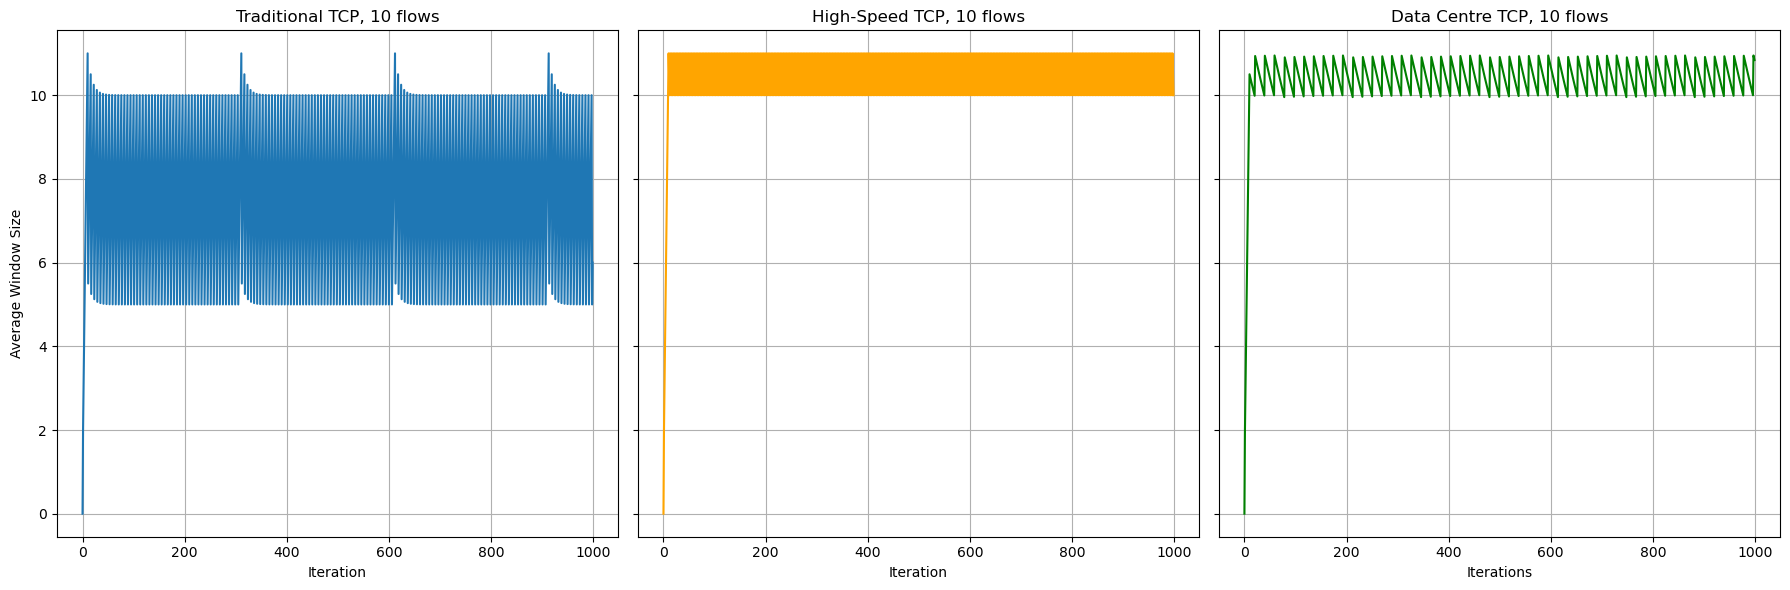

In [111]:
experiment2(n_users=10)

# 50 TCP flows

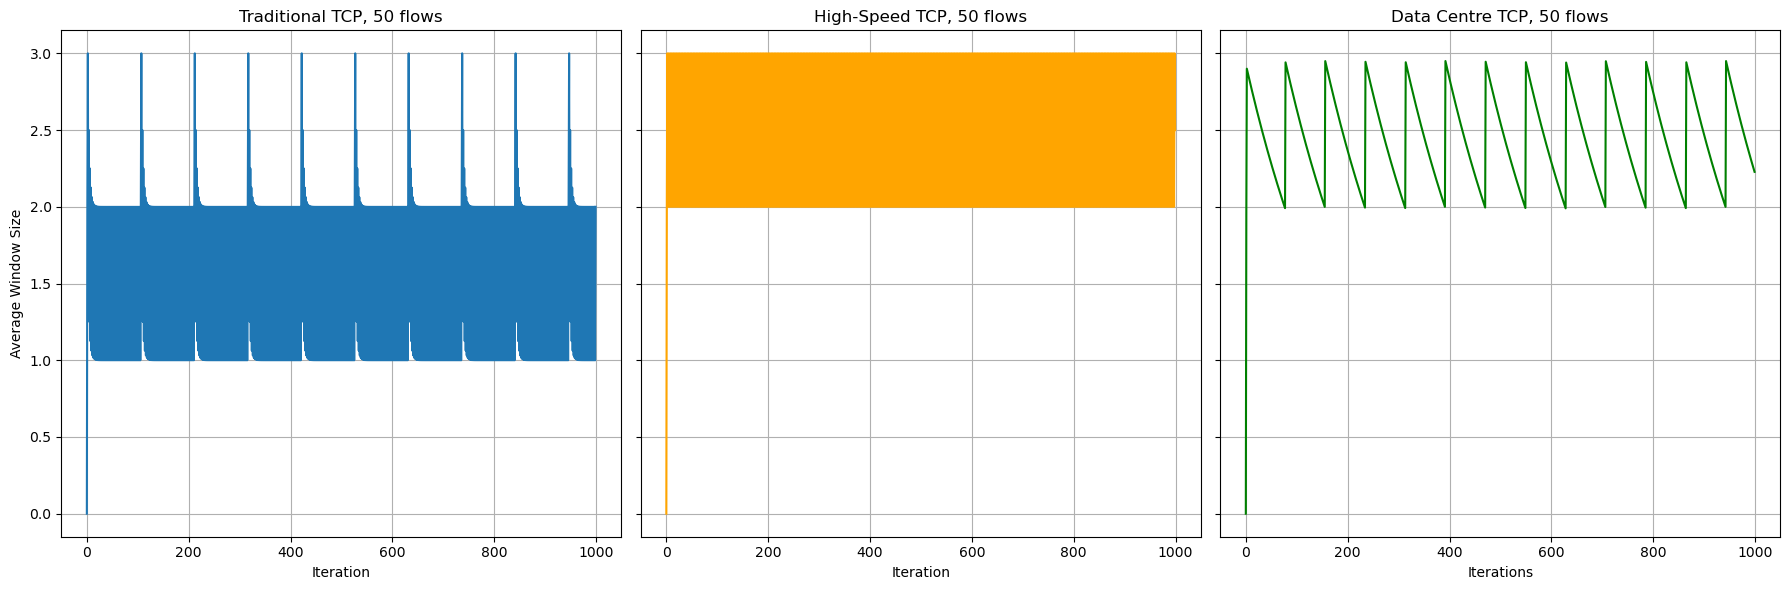

In [112]:
experiment2(n_users=50)

# 100 TCP flows

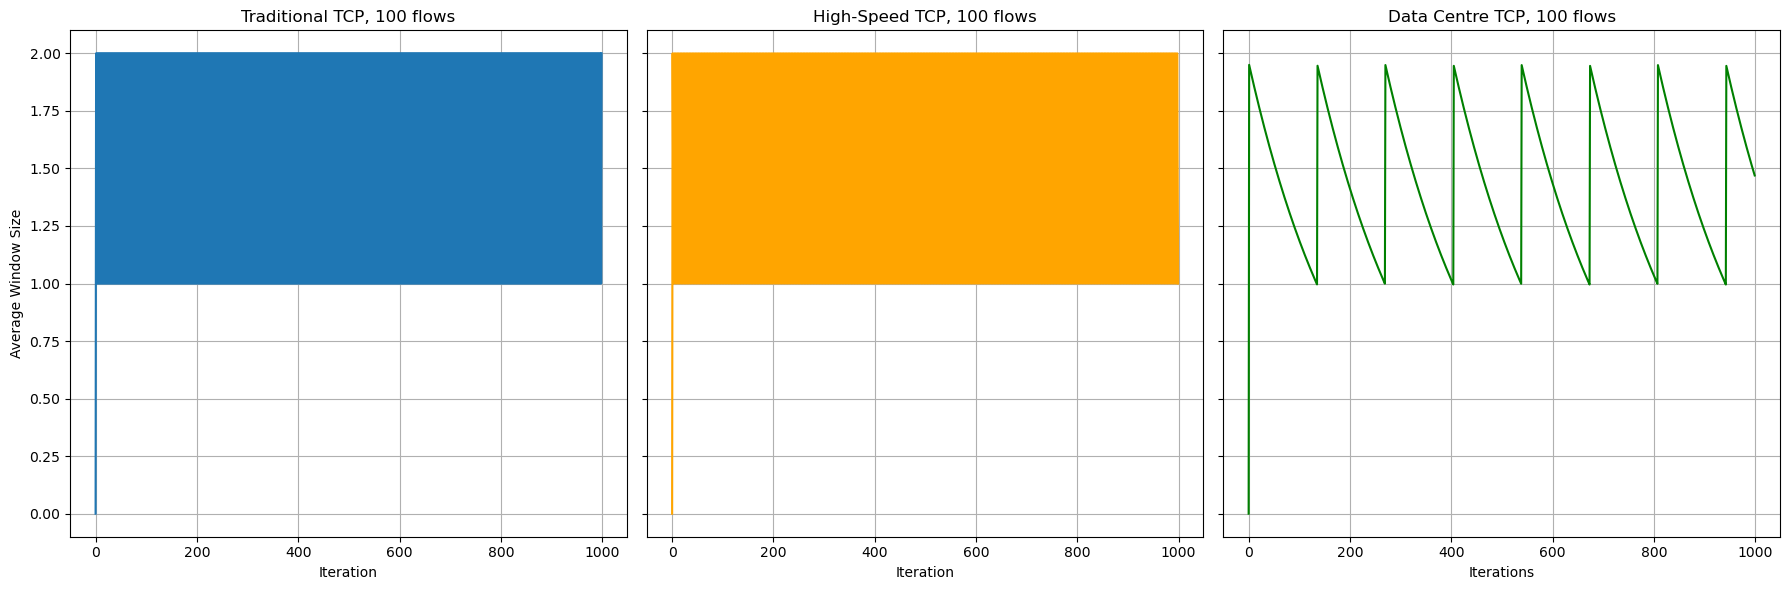

In [113]:
experiment2(n_users=100)